> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Multivariate Input ,Univariate Output CNN ,Multi-Step
TThis tutorial is to demonstrate the process in build CNN for Multivariate Input, Univariate Output  for Multi Step. It consists of 2 major part which are :

The Demostration of Building CNN using Synthetic data and Exercise of building CNN using Daily_Demand_Forecasting_Order data. First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Standardization and Batching the Data) <br>
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First , let's us import the package needed

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import math

In [2]:
# Function needed

# Data Sequencing Function
def multivariate_univariate_multi_step(sequence,window_size,n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep -1
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix-1:out_ix,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0],train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 70
window_size = 4
n_step = 2
learning_rate = 0.001
# seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

## Data Visualization

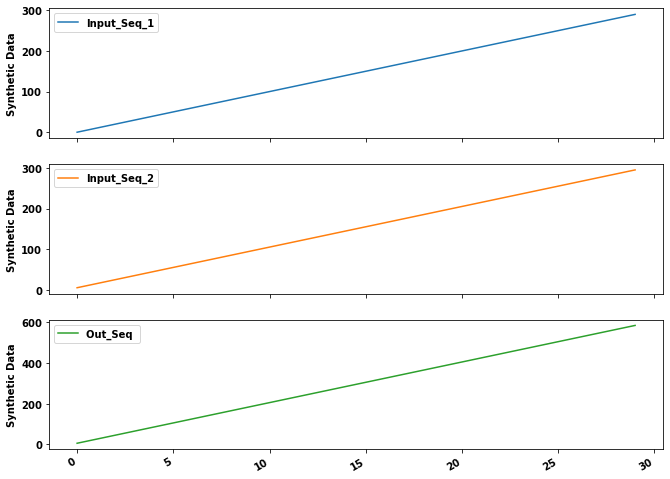

In [5]:
# Store the Synthetic Data in dataframe and create column name
dataframe = pd.DataFrame(dataset,
                        columns=['Input_Seq_1', 'Input_Seq_2', 'Out_Seq '])
axes = dataframe[dataframe.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Synthetic Data')

## Data Splitting

In [6]:
split_data = round(len(dataset) * split_ratio)

# split data by indexing
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Standardization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [7]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.reshape(-1, 1))

In [8]:
# transform after scaling
train_data_standard  = train_data_standard.reshape(train_data.shape[0], train_data.shape[1])
print("test_data_standardlized" + str(train_data_standard .shape))

test_data_standard = test_data_standard.reshape(test_data.shape[0], test_data.shape[1])
print("test_data_standardlized" + str(test_data_standard.shape))

test_data_standardlized(21, 3)
test_data_standardlized(9, 3)


## Data Sequencing
Sequencing the data

In [9]:
trainX, trainY = multivariate_univariate_multi_step(train_data_standard, window_size,n_step)
testX, testY = multivariate_univariate_multi_step(test_data_standard, window_size,n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(17, 4, 2) trainY shape:(17, 2)

testX shape:(5, 4, 2) testY shape:(5, 2)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform Data Transpose to make it can feed into CNN model

In [10]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [11]:
# 3D Data Preparation
trainX = torch.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
trainY = torch.reshape(trainY, (trainY.shape[0], n_step))
testX = torch.reshape(testX, (testX.shape[0], trainX.shape[1], trainX.shape[2]))
testY = torch.reshape(testY, (testY.shape[0], n_step))

## Data Transpose

In [12]:
# Data Transpose
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)
print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([17, 2, 4]) trainY shape:torch.Size([17, 2])

after transpose shape:torch.Size([5, 2, 4]) testY shape:torch.Size([5, 2])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [13]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=1, shuffle=False)

## CNN Configuration
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as number of convolution layer , pooling layer and the linear layer

Second part of the method consist of forward() method , it allow user to control the flow of input data.For example , when the data pass in ,it will go throught the conv1 layer first then the output of conv1 layer will become the input for the ReLu activation function.The output of activation output will pass to the next pooling layer.

In [14]:
class CNN_Multivariate_Univariate(nn.Module):

    def __init__(self,timeseries,n_step):
        super(CNN_Multivariate_Univariate, self).__init__()
        
        self.timeseries = timeseries
        self.n_step = n_step
        
        # Conv1d1d kernel_size is base on the number of time series
        self.conv1 = nn.Conv1d(in_channels=timeseries, out_channels=10, kernel_size=2)
        
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,n_step)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.poo1(x)
        x = x.view(-1,10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [15]:
# Input te attribute need by the model
model = CNN_Multivariate_Univariate(timeseries =trainX.shape[1],n_step = n_step)
# Examine the model configuration 
print(model.eval())
# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 10, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)


In [16]:
#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)

model.apply(weights_init)

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 10, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)

## Training

In [17]:
# Start Training
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

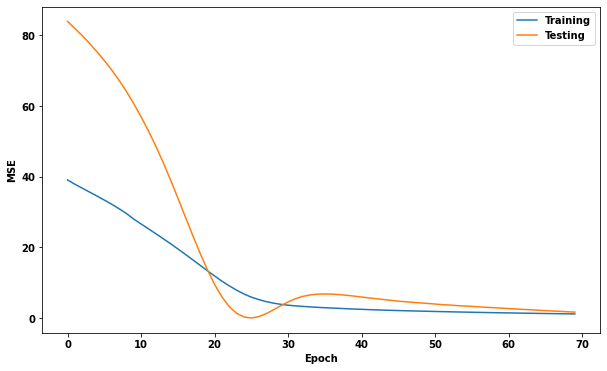

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [19]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [20]:
# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [21]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [22]:
# Examine the test data and forecast result 
print("Test Data \t Forecast Result")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data 	 Forecast Result
[485.      504.99997]		[507.56387 564.67847]
[504.99997 525.     ]		[531.11896 592.1334 ]
[525. 545.]		[554.6741 619.5884]
[545. 565.]		[578.2301  647.03015]
[565. 585.]		[601.7863 674.4702]


In [23]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 29.04 RMSE
Test Score: 30.10 RMSE


## Exercise for Multivariate (Solution)
Predict index of PM2.5 for Beijing 
Data Source : https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

In [68]:
air = pd.read_csv(r"..\..\datasets\others\Beijing Air Quality.csv",sep=',')
air.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


In [69]:
air["Date"] = air["year"].map(str) + '-'+ air["month"].map(str)+ '-' + air["day"].map(str) + '-' + air["hour"].map(str) 
air = air.set_index('Date')
air.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Date,,,,,,,,,,,,,,,,,,
2013-3-1-0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
2013-3-1-1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2013-3-1-2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
2013-3-1-3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
2013-3-1-4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


In [70]:
air = air.drop(columns = ['No','year','month','day','hour','wd','station'])
air.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
Date,,,,,,,,,,,
2013-3-1-0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4
2013-3-1-1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,4.7
2013-3-1-2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,5.6
2013-3-1-3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,3.1
2013-3-1-4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,2.0


In [83]:
air[air.columns[1:]]

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
Date,,,,,,,,,,
2013-3-1-0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4
2013-3-1-1,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,4.7
2013-3-1-2,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,5.6
2013-3-1-3,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,3.1
2013-3-1-4,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
2017-2-28-19,37.0,3.0,36.0,400.0,60.0,12.5,1013.5,-16.2,0.0,2.4
2017-2-28-20,43.0,4.0,48.0,500.0,43.0,11.6,1013.6,-15.1,0.0,0.9
2017-2-28-21,33.0,5.0,39.0,500.0,50.0,10.8,1014.2,-13.3,0.0,1.1


In [25]:
# Add aditional coloumn name "Day"
demand.insert(1,"Day",range(1,len(demand)+1))
# set the "Day" column as index
demand = demand.set_index('Day')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
3,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
4,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
5,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [26]:
# Slice the 3th column to end of the data 
demand_slice = demand.iloc[:,2:]
# Print first 5 days of data to make sure it is correctly slicing 
demand_slice.iloc[0:10]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,
1,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
3,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
4,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
5,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
6,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364
7,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973,263.043
8,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,248.958
9,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458,344.291


In [27]:
# print the data shape to make sure we are correct slicing 
demand_value = demand_slice.values
demand_value.shape

(60, 11)

## Data Visualization

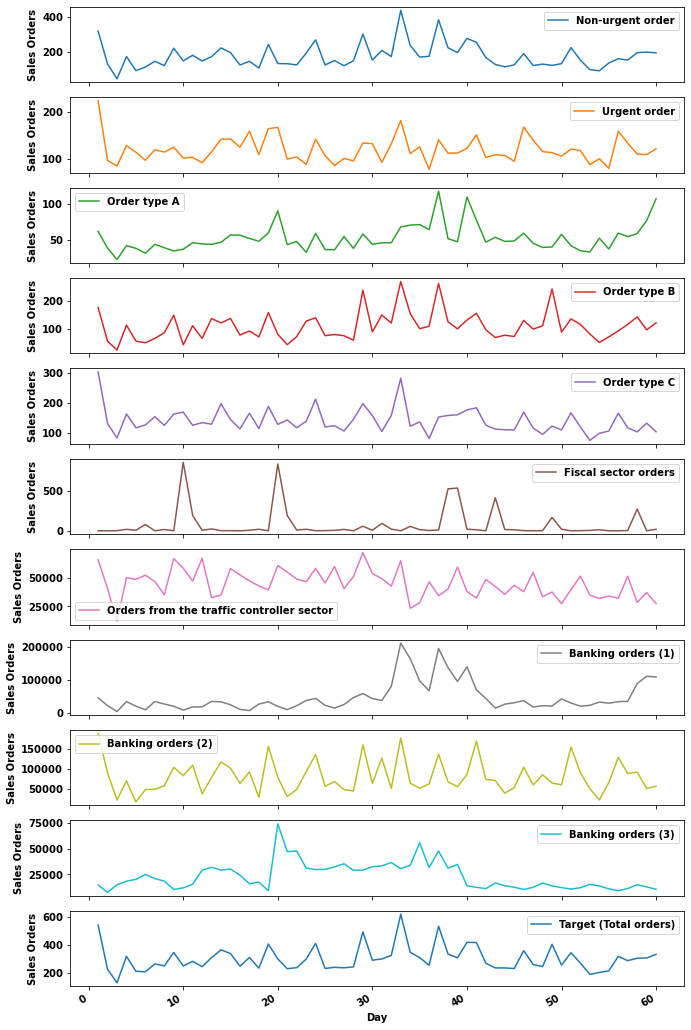

In [28]:
# Visualize the multivariate plot 
axes = demand_slice[demand_slice.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 20), subplots=True)
for ax in axes:
    ax.set_ylabel('Sales Orders')

## Hyperparameter
Define the hyper parameter that need to tune the model

In [29]:
#Hyperameter
split_ratio_demand = 0.80
num_epochs_demand  = 130
window_size_demand = 4
n_step_demand = 2
learning_rate_demand = 0.01
batch_size_demand = 5

#seed
torch.manual_seed(123)

## Data Splitting

In [30]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [31]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
train_time = demand.index[:-split_data_demand]
test_time = demand.index[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(39, 11)
test_data_shape
(21, 11)


## Data Normalization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [32]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler_demand = MinMaxScaler().fit(train_data_demand .reshape(-1, 1))
train_data_standard_demand = scaler_demand.transform(train_data_demand .reshape(-1, 1))
test_data_standard_demand = scaler_demand.transform(test_data_demand .reshape(-1, 1))

In [33]:
# Transform after scaling
train_data_standard_demand  = train_data_standard_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("train_data_normalized"+str(train_data_standard_demand.shape))

test_data_standard_demand = test_data_standard_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_standard_demand.shape))

train_data_normalized(39, 11)
test_data_normalized(21, 11)


## Data Seqeuncing

In [34]:
# Data Seqeuncing

trainX_demand ,trainY_demand =  multivariate_univariate_multi_step(train_data_standard_demand ,window_size_demand,n_step_demand)
testX_demand , testY_demand = multivariate_univariate_multi_step(test_data_standard_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
,window_size_demand,n_step_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testY_demand.shape}")

trainX_demand shape:(35, 4, 10) trainY_demand shape:(35, 2)

testX_demand shape:(17, 4, 10) testX_demand shape:(17, 2)


## Data Transform

In [35]:
#  Data Transform

# make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

#3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))

In [36]:
print(f"trainX_demand shape : {trainX_demand.shape}")
print(f"trainY_demand shape : {trainY_demand.shape}")
print(f"testX_demand shape  : {testX_demand.shape}")
print(f"testY_demand_demand shape : {testY_demand.shape}")

trainX_demand shape : torch.Size([35, 4, 10])
trainY_demand shape : torch.Size([35, 2])
testX_demand shape  : torch.Size([17, 4, 10])
testY_demand_demand shape : torch.Size([17, 2])


## Data Transpose

In [37]:
# trnaspose to suit CNN model
# Input: (N, C, L_in) in Conv1D
trainX_demand = torch.transpose(trainX_demand,1, 2)
testX_demand = torch.transpose(testX_demand, 1, 2)
print(f"after transpose trainX shape:{trainX_demand.shape} trainY shape:{trainY_demand.shape}\n")
print(f"after transpose shape:{testX_demand.shape} testY shape:{testY_demand.shape}")

after transpose trainX shape:torch.Size([35, 10, 4]) trainY shape:torch.Size([35, 2])

after transpose shape:torch.Size([17, 10, 4]) testY shape:torch.Size([17, 2])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [38]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

In [39]:
model_demand = CNN_Multivariate_Univariate(timeseries =trainX_demand.shape[1],n_step = n_step)
print(model_demand.eval())
optimizer_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate_demand)
loss_fn_demand = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(10, 10, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)


In [40]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)

model_demand.apply(weights_init)

CNN_Multivariate_Univariate(
  (conv1): Conv1d(10, 10, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [41]:
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimizer_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

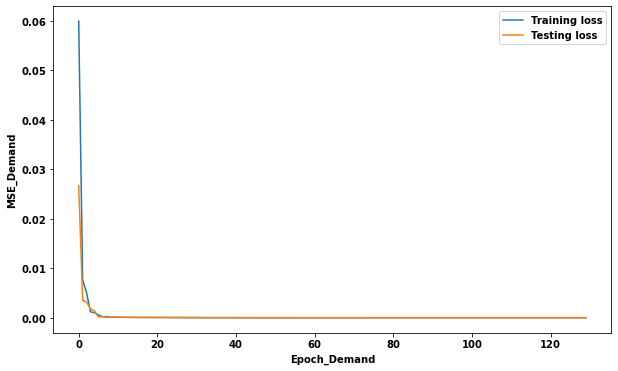

In [42]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

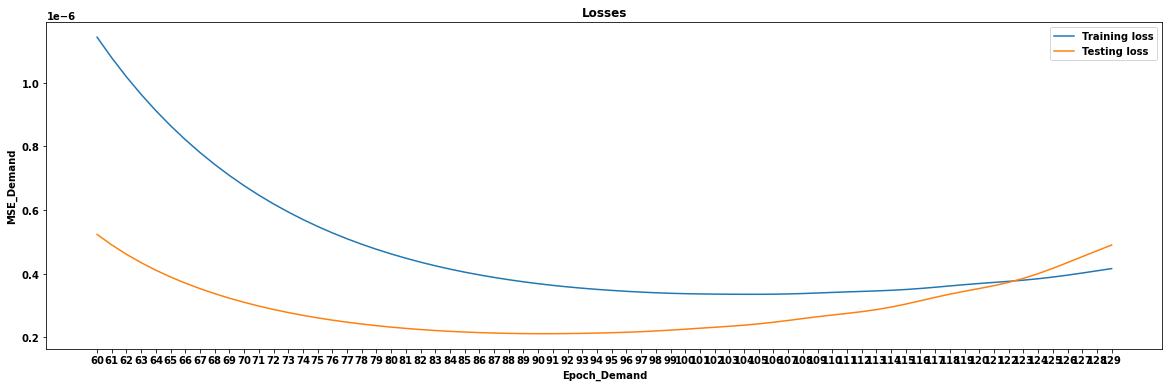

In [43]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 60
end_epoch = 130
plt.figure(figsize=(20,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [44]:
# Section 1 : make predictions 
with torch.no_grad():
    y_train_prediction_demand = model_demand(trainX_demand)
    y_test_prediction_demand = model_demand(testX_demand)

# Section 2 : Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [45]:
# Section 3 : Invert predictions
y_train_prediction_demand = scaler_demand.inverse_transform(y_train_prediction_demand)
y_train_demand = scaler_demand.inverse_transform(trainY_demand)
y_test_prediction_demand = scaler_demand.inverse_transform(y_test_prediction_demand)
y_test_demand = scaler_demand.inverse_transform(testY_demand)

In [46]:
print("Test Data \t\t Forecast Result")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

Test Data 		 Forecast Result
[234.50299242 234.72399075]		[395.22597146 315.20889428]
[234.72399075 230.06400902]		[406.4118489  315.80371256]
[230.06400902 357.39398943]		[378.40010309 318.3822714 ]
[357.39398943 259.24600688]		[397.33077341 321.17687828]
[259.24600688 244.23500576]		[360.77748406 319.54259837]
[244.23500576 402.60699198]		[350.63930237 318.762414  ]
[402.60699198 255.06100735]		[371.94767743 317.79029585]
[255.06100735 342.60599616]		[377.95153874 319.59533605]
[342.60599616 268.64000403]		[388.11481494 320.70096483]
[268.64000403 188.60100591]		[365.58935618 316.90218549]
[188.60100591 202.02199786]		[427.61984593 311.84358337]
[202.02199786 213.50900941]		[428.29426086 311.84848464]
[213.50900941 316.8490067 ]		[405.69038177 319.29645653]
[316.8490067  286.41198931]		[353.5439918  325.08475992]
[286.41198931 303.44699492]		[368.41876209 319.43310397]
[303.44699492 304.94999428]		[406.97333854 314.76738776]
[304.94999428 331.90000219]		[440.45255053 310.84097931]


In [47]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (17, 2)
y_test_demand_pred_shape : (17, 2)


In [48]:
# calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 147.81 RMSE
Test Score: 135.14 RMSE


## Forecast Result

### Plot Explanation
- Blue Line-Indicate as test data before sequencing
- Green Line-Indicate as the testY data after sequencing
- Red Line-Indicate as the predicted testY data (Forecast) after sequencing

Window size = 4 , hence the time need start from +3 due to taking 3 data point as x-feature.

- **x-feature = window size -1**

[ time+3,time+4 ] - This is because n_step_demand = 2 .If n_step_demand = 3 ,[ time+3,time+4,time_5 ] is need

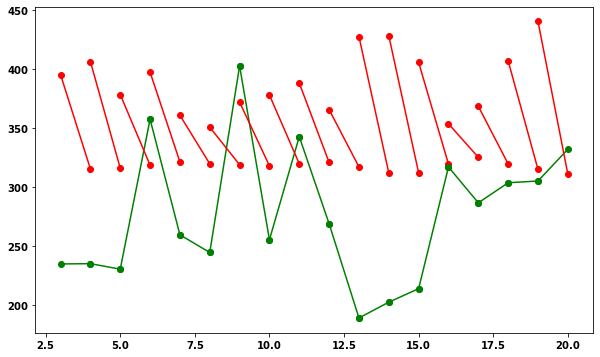

In [49]:
# Plot testY and predictionY data
plt.figure(figsize=(10,6))
for time in range(len(y_test_demand)):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
    
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')

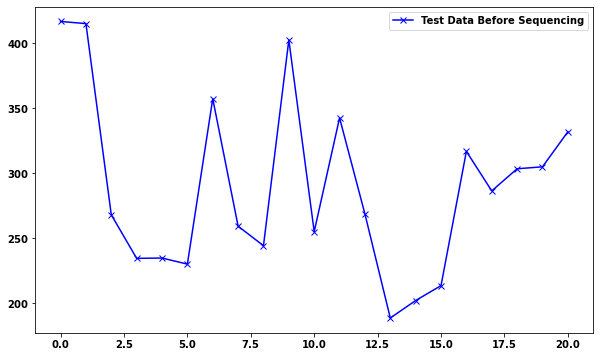

In [50]:
# Plot Original Test Data
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
plt.legend()

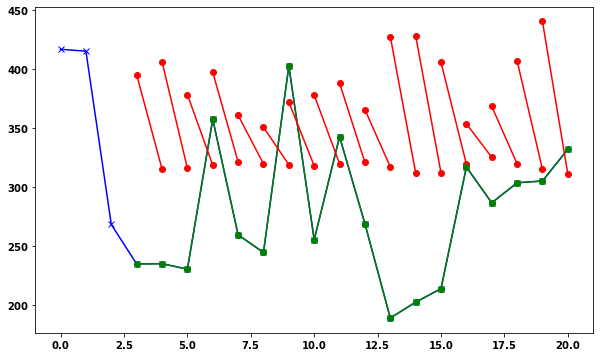

In [51]:

# Plot orginal test data , testY and predict testY after sequencing 
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
for time in range(17):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
        
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
2. [Multistep Time Series Forecasting with LSTMs in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data